# Rasterization

- Requires a template grid definition or the output with dimensions and a transformation matrix
- The template can come from an existing raster or created manually
- Input vectors composed of geometry, value pairs
- multiple values can be burned into the same pixel with `merge_alg` parameter, either `replace` or `add`
- a pixel-matching algorithm, `all_touched` bool parameter
- _point_ rasterization is used to summarize presence/absence, count or sum values

In [3]:
import sys 
sys.path.append('../')

# Rasterizing points

In [4]:
from helpers import cycle_hire_osm

In [45]:
import rasterio.transform
import rasterio.features
import rasterio.plot
import math
import matplotlib.pyplot as plt
import geopandas as gpd 
import numpy as np

In [12]:
cycle_hire_osm_proj = cycle_hire_osm.to_crs(27700)

In [13]:
bounds = cycle_hire_osm_proj.total_bounds
res = 1000
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res
)
transform

Affine(1000.0, 0.0, 523038.6145227547,
       0.0, -1000.0, 184971.40854297916)

In [14]:
rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

(11, 16)

>Approach 1
>
>Create a raster representing presence or absence of cycle hire points

In [15]:
g = [(g, 1) for g in cycle_hire_osm_proj.geometry]
g[:5]

[(<POINT (532353.838 182857.655)>, 1),
 (<POINT (529848.35 183337.175)>, 1),
 (<POINT (530635.62 182608.992)>, 1),
 (<POINT (532540.398 182495.756)>, 1),
 (<POINT (530432.094 182906.846)>, 1)]

In [16]:
ch_raster1 = rasterio.features.rasterize(
    shapes=g, 
    out_shape=shape, 
    transform=transform
)
ch_raster1

array([[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

>Approach 2
>
>Count the number of stations

In [17]:
g = [(g, 1) for g in cycle_hire_osm_proj.geometry]
ch_raster2 = rasterio.features.rasterize(
    shapes=g, 
    out_shape=shape, 
    transform=transform, 
    merge_alg=rasterio.enums.MergeAlg.add
)
ch_raster2

array([[ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  3,  3],
       [ 0,  0,  0,  1,  3,  3,  5,  5,  8,  9,  1,  3,  2,  6,  7,  0],
       [ 0,  0,  0,  8,  5,  4, 11, 10, 12,  9, 11,  4,  8,  5,  4,  0],
       [ 0,  1,  4, 10, 10, 11, 18, 16, 13, 12,  8,  6,  5,  2,  3,  0],
       [ 3,  3,  9,  3,  5, 14, 10, 15,  9,  9,  5,  8,  0,  0, 12,  2],
       [ 4,  5,  9, 11,  6,  7,  7,  3, 10,  9,  4,  0,  0,  0,  0,  0],
       [ 4,  0,  7,  8,  8,  4, 11, 10,  7,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  3,  0,  0,  1,  4,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  1,  0,  1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

>Method 3
>
>The data contains a capacity for each station. Calculate the capacity of each grid cell
>
>1. Extract geometries and attributes of interest
>2. Filter nodata values

In [18]:
g = ([(g,v) for g, v in 
    cycle_hire_osm_proj[['geometry', 'capacity']]
     .dropna(subset='capacity')
     .to_numpy().tolist()]
    )
g[:5]

[(<POINT (532353.838 182857.655)>, 14.0),
 (<POINT (530635.62 182608.992)>, 11.0),
 (<POINT (532620.775 181944.736)>, 20.0),
 (<POINT (527891.578 181374.392)>, 6.0),
 (<POINT (530399.064 181205.925)>, 17.0)]

In [19]:
ch_raster3 = rasterio.features.rasterize(
    shapes=g, 
    out_shape=shape, 
    transform=transform, 
    merge_alg=rasterio.enums.MergeAlg.add 
)
ch_raster3

array([[  0.,   0.,   0.,   0.,   0.,  11.,  34.,   0.,   0.,   0.,   0.,
          0.,   0.,  11.,  35.,  24.],
       [  0.,   0.,   0.,   7.,  30.,  46.,  60.,  73.,  72.,  75.,   6.,
         50.,  25.,  47.,  36.,   0.],
       [  0.,   0.,   0.,  89.,  36.,  31., 167.,  97., 115.,  80., 138.,
         61.,  65., 109.,  43.,   0.],
       [  0.,  11.,  42., 104., 108., 138., 259., 206., 203., 135., 107.,
         37.,   0.,  25.,  60.,   0.],
       [ 88.,  41.,  83.,  28.,  64., 115.,  99., 249., 107., 117.,  60.,
         33.,   0.,   0.,   0.,   0.],
       [  0.,  89., 107.,  95.,  73., 119.,  69.,  23., 140., 141.,  46.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  55.,  97., 101.,  59., 119., 109.,  75.,  12.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,  10.,  23.,   0.,   0.,   5.,  41.,   0.,   8.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.],
       [  0.,  19.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   

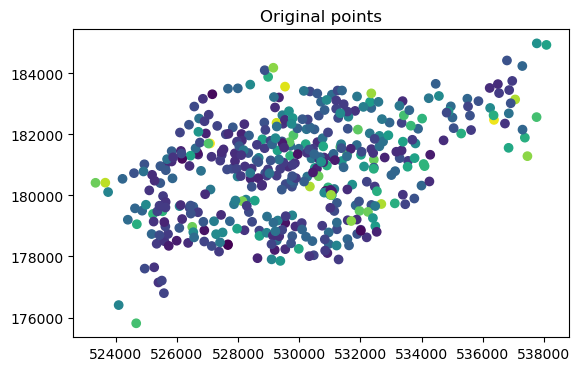

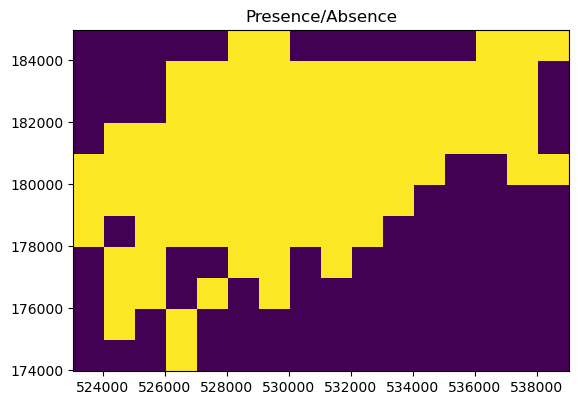

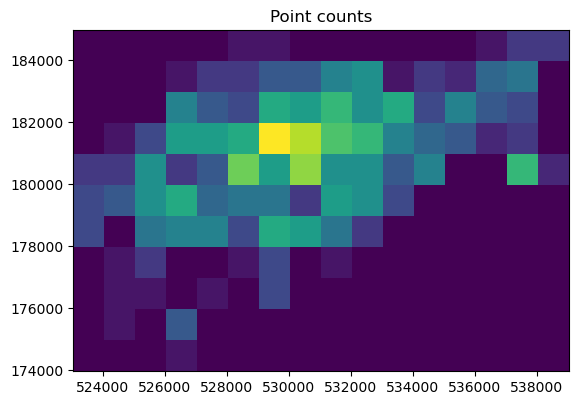

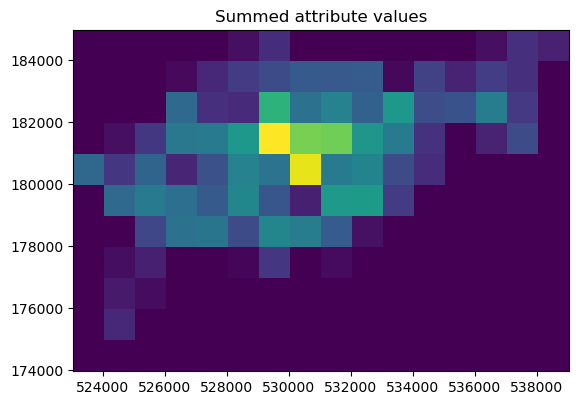

In [36]:
# Input points
fig, ax = plt.subplots()
cycle_hire_osm_proj.plot(column='capacity', ax=ax)
ax.set_title("Original points");
# Presence/Absence
fig, ax = plt.subplots()
rasterio.plot.show(ch_raster1, transform=transform, ax=ax)
ax.set_title("Presence/Absence");
# Point counts
fig, ax = plt.subplots()
rasterio.plot.show(ch_raster2, transform=transform, ax=ax);
ax.set_title("Point counts")
# Summed attribute values
fig, ax = plt.subplots()
rasterio.plot.show(ch_raster3, transform=transform, ax=ax);
ax.set_title("Summed attribute values");

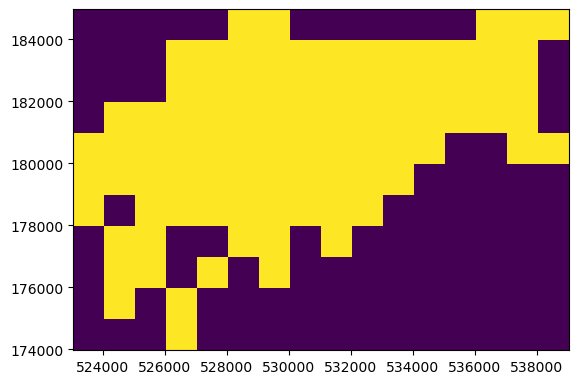

<Axes: >

In [25]:
rasterio.plot.show(ch_raster1, transform=transform)

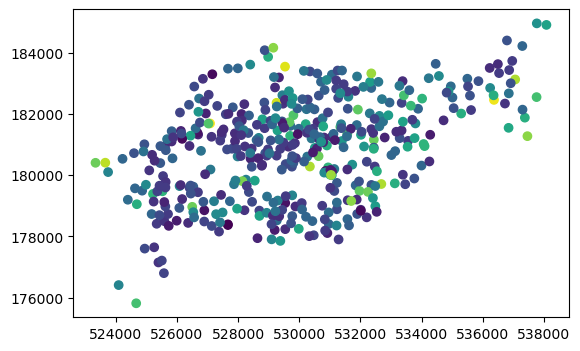

In [29]:
fig, ax = plt.subplots()
cycle_hire_osm_proj.plot(column='capacity', ax=ax);

# Rasterizing Lines and Polygons

In [37]:
from helpers import us_states

In [39]:
california = us_states[us_states.NAME == 'California']
california

,GEOID,NAME,REGION,AREA,total_pop_10,total_pop_15,geometry
26,06,California,West,409747.075055,36637290.0,38421464.0,"MULTIPOLYGON (((-118.60338 33.4781, -118.3683 ..."


In [40]:
california_borders = california.boundary
california_borders

26    MULTILINESTRING ((-118.60338 33.4781, -118.368...
dtype: geometry

In [42]:
bounds = california_borders.total_bounds 
res = 0.5 
transform = rasterio.transform.from_origin(
    west=bounds[0], 
    north=bounds[3], 
    xsize=res, 
    ysize=res 
)
rows = math.ceil((bounds[3] - bounds[1]) / res)
cols = math.ceil((bounds[2] - bounds[0]) / res)
shape = (rows, cols)
shape

(19, 21)

In [43]:
california_raster1 = rasterio.features.rasterize(
    [(g,1) for g in california_borders], 
    out_shape=shape, 
    transform=transform, 
    all_touched=True, 
    fill=np.nan, 
    dtype=np.float64
)

In [44]:
california_raster2 = rasterio.features.rasterize(
    [(g, 1) for g in california.geometry],
    out_shape=shape,
    transform=transform,
    fill=np.nan,
    dtype=np.float64
)

>Illustrate selected pixels

In [47]:
height = california_raster1.shape[0]
width = california_raster1.shape[1]
cols, rows = np.meshgrid(np.arange(width), np.arange(height))
x, y = rasterio.transform.xy(transform, rows, cols)
x = np.array(x).flatten() 
y = np.array(y).flatten() 
z = california_raster1.flatten() 
geom = gpd.points_from_xy(x, y, crs=california.crs)
pnt = gpd.GeoDataFrame(data={'value': z}, geometry=geom)
pnt

,value,geometry
0,1.0,POINT (-124.15959 41.75952)
1,1.0,POINT (-123.65959 41.75952)
2,1.0,POINT (-123.15959 41.75952)
3,1.0,POINT (-122.65959 41.75952)
4,1.0,POINT (-122.15959 41.75952)
...,...,...
394,1.0,POINT (-116.15959 32.75952)
395,1.0,POINT (-115.65959 32.75952)
396,1.0,POINT (-115.15959 32.75952)
397,1.0,POINT (-114.65959 32.75952)


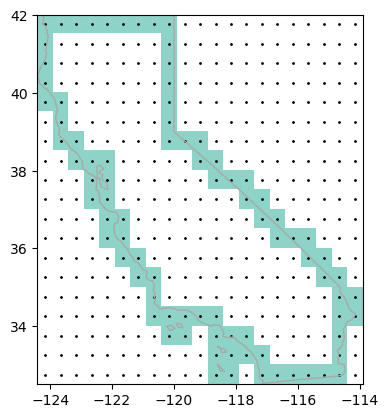

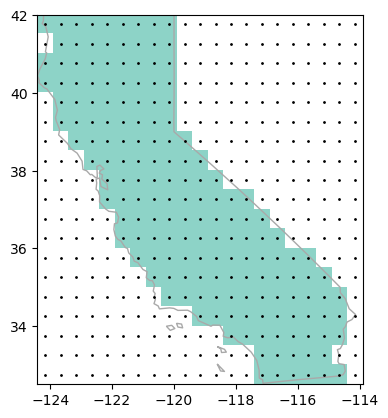

In [48]:
# Line rasterization
fig, ax = plt.subplots()
rasterio.plot.show(california_raster1, transform=transform, ax=ax, cmap='Set3')
gpd.GeoSeries(california_borders).plot(ax=ax, edgecolor='darkgrey', linewidth=1)
pnt.plot(ax=ax, color='black', markersize=1);
# Polygon rasterization
fig, ax = plt.subplots()
rasterio.plot.show(california_raster2, transform=transform, ax=ax, cmap='Set3')
california.plot(ax=ax, color='none', edgecolor='darkgrey', linewidth=1)
pnt.plot(ax=ax, color='black', markersize=1);